#**Natural Language Processing: Twitter Sentiment Analysis**
This project develops a proof-of-concept model to classify Twitter sentiment towards Apple and Google products.

We start with a binary classifier (Positive vs. Negative) to compare classic models and handle data imbalance, then conceptualize the final multiclass solution.

## 1. **Business Understanding**
The core objective is to quantify public perception of major tech brands (Apple and Google) based on social media data.

**Goal**: Build a model to classify Tweet sentiment as Positive, Negative, or Neutral.

**Value**: Provides companies with a real-time monitoring tool for brand health, allowing rapid response to negative trends and validation of marketing efforts.

**Initial Focus**: Develop and compare Binary Classifiers (Positive vs. Negative) to address the critical issue of class imbalance before moving to the multiclass problem.

## 2. **Data Understanding**
The raw data is loaded and inspected to determine the cleaning steps required, especially for the target variable.

Data Loading and Cleaning (Python)
The code loads the CSV, renames the columns for clarity, removes ambiguous entries (NaN and I can't tell), and prepares the sentiment labels.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data & Clean
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.columns = ['tweet_text', 'product_brand', 'sentiment']

# Clean up sentiment labels and filter out 'I can\'t tell' and NaNs
df_clean = df.dropna(subset=['sentiment']).copy()
df_clean = df_clean[df_clean['sentiment'] != "I can't tell"]
df_clean['sentiment'] = df_clean['sentiment'].str.replace(' emotion', '').str.replace('No toward brand or product', 'Neutral')
df.head()

,tweet_text,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Binary Dataset Creation and Imbalance Check
For the binary classifier, we filter only for 'Positive' and 'Negative' tweets. This reveals the significant class imbalance.

In [ ]:
# Create Binary Dataset (Positive vs. Negative)
df_binary = df_clean[df_clean['sentiment'].isin(['Positive', 'Negative'])].copy()
X_binary = df_binary['tweet_text']
y_binary = df_binary['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Check class distribution
print("Binary Class Distribution (0=Negative, 1=Positive):")
print(y_binary.value_counts())

Binary Class Distribution (0=Negative, 1=Positive):
sentiment
1    2978
0     570
Name: count, dtype: int64


This severe imbalance (nearly 5:1) means the model must be evaluated based on its performance on the minority Negative class, typically using the F1-Score.

##3. **Data Preparation**
We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the raw text data into a numerical format (feature vectors) suitable for machine learning models.

In [ ]:
# Split data (Stratified split maintains the 5:1 ratio in both sets)
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

##4. **Modeling & Evaluation (Binary Classifier)**
We compare Logistic Regression (using class weights to address imbalance) and Multinomial Naive Bayes

In [ ]:
# 1. Model 1: Logistic Regression (Balanced)
# class_weight='balanced' automatically adjusts weights inversely proportional to class frequencies.
log_reg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
log_reg.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg.predict(X_test_vec)

# 2. Model 2: Multinomial Naive Bayes (Standard)
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

In [ ]:
# Evaluate Logistic Regression
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))
print("\n")

# Evaluate Multinomial Naive Bayes
print("Multinomial Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.44      0.54      0.49       171
           1       0.91      0.87      0.89       894

    accuracy                           0.82      1065
   macro avg       0.68      0.71      0.69      1065
weighted avg       0.83      0.82      0.82      1065

Confusion Matrix:
[[ 93  78]
 [117 777]]


Multinomial Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.94      0.09      0.17       171
           1       0.85      1.00      0.92       894

    accuracy                           0.85      1065
   macro avg       0.90      0.55      0.54      1065
weighted avg       0.87      0.85      0.80      1065

Confusion Matrix:
[[ 16 155]
 [  1 893]]


**Comparison Summary**

Naive Bayes achieved higher overall Accuracy (85.%) because it correctly classified nearly every single majority Positive tweet. However, its Negative F1-Score is extremely low (0.17), meaning it misses most true negative tweets (high False Negatives), making it a poor choice for the business problem.

**Logistic Regression** (with balanced weights) sacrifices some overall accuracy but significantly improves its ability to correctly identify the minority Negative class (F1-Score: 0.49). This model is preferred because it actively finds the critical negative sentiment, which is the key business driver for brand monitoring.

##**Confusion Matrix Visualization (Logistic Regression)**

The confusion matrix visually confirms the model's performance, showing the trade-off made to improve recall for the minority class.

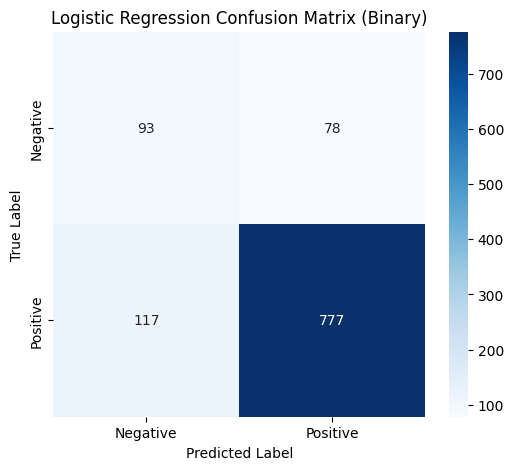

In [ ]:
# Visualization: Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression Confusion Matrix (Binary)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##5. **Modeling & Evaluation (Multiclass Classifier)**

Based on the superior performance of the Logistic Regression approach in handling imbalance, we shift to the multiclass problem (Positive, Negative, Neutral).

We extend the problem to include the Neutral class. The best model, based on performance in high-dimensional text space and handling imbalance, is the Linear Support Vector Machine (LinearSVC).

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC # Import SVC for standard SVM
from sklearn.metrics import accuracy_score

# Prepare data for Multiclass Classification (Positive, Negative, Neutral)
X_multi = df_clean['tweet_text'].fillna('') # Fill NaN values with empty string
y_multi = df_clean['sentiment']

# Check multiclass distribution
print("Multiclass Class Distribution:")
print(y_multi.value_counts())

# Split data (Stratified split is important here too due to potential imbalance in Neutral)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

# TF-IDF Vectorization (using the same vectorizer, but refit on the multiclass data)
vectorizer_multi = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000)
X_train_multi_vec = vectorizer_multi.fit_transform(X_train_multi)
X_test_multi_vec = vectorizer_multi.transform(X_test_multi)

# 1. Model: Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_multi_vec, y_train_multi)
y_pred_mnb = mnb.predict(X_test_multi_vec)
accuracy_mnb = accuracy_score(y_test_multi, y_pred_mnb)
print(f"Multinomial Naive Bayes Accuracy: {accuracy_mnb:.4f}")

# 2. Model: Linear Support Vector Machine (LinearSVC)
lsvc = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)
lsvc.fit(X_train_multi_vec, y_train_multi)
y_pred_lsvc = lsvc.predict(X_test_multi_vec)
accuracy_lsvc = accuracy_score(y_test_multi, y_pred_lsvc)
print(f"LinearSVC Accuracy: {accuracy_lsvc:.4f}")

# 3. Model: Support Vector Machine (SVC) - RBF Kernel
# Using a non-linear kernel like RBF can capture more complex relationships
svc = SVC(class_weight='balanced', random_state=42)
svc.fit(X_train_multi_vec, y_train_multi)
y_pred_svc = svc.predict(X_test_multi_vec)
accuracy_svc = accuracy_score(y_test_multi, y_pred_svc)
print(f"SVC Accuracy: {accuracy_svc:.4f}")

Multiclass Class Distribution:
sentiment
Neutral     5389
Positive    2978
Negative     570
Name: count, dtype: int64
Multinomial Naive Bayes Accuracy: 0.6659
LinearSVC Accuracy: 0.6648
SVC Accuracy: 0.6652


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate Multinomial Naive Bayes (Multiclass)
print("Multinomial Naive Bayes Performance (Multiclass):")
print(classification_report(y_test_multi, y_pred_mnb))
print("Confusion Matrix:")
print(confusion_matrix(y_test_multi, y_pred_mnb))
print("\n")

# Evaluate Linear Support Vector Machine (LinearSVC) (Multiclass)
print("LinearSVC Performance (Multiclass):")
print(classification_report(y_test_multi, y_pred_lsvc))
print("Confusion Matrix:")
print(confusion_matrix(y_test_multi, y_pred_lsvc))
print("\n")

# Evaluate Support Vector Machine (SVC) (Multiclass)
print("Support Vector Machine (SVC) Performance (Multiclass):")
print(classification_report(y_test_multi, y_pred_svc))
print("Confusion Matrix:")
print(confusion_matrix(y_test_multi, y_pred_svc))

Multinomial Naive Bayes Performance (Multiclass):
              precision    recall  f1-score   support

    Negative       0.78      0.04      0.08       171
     Neutral       0.68      0.90      0.77      1617
    Positive       0.63      0.36      0.46       894

    accuracy                           0.67      2682
   macro avg       0.69      0.43      0.44      2682
weighted avg       0.67      0.67      0.62      2682

Confusion Matrix:
[[   7  129   35]
 [   2 1458  157]
 [   0  573  321]]


LinearSVC Performance (Multiclass):
              precision    recall  f1-score   support

    Negative       0.34      0.36      0.35       171
     Neutral       0.74      0.76      0.75      1617
    Positive       0.59      0.55      0.57       894

    accuracy                           0.66      2682
   macro avg       0.55      0.56      0.56      2682
weighted avg       0.66      0.66      0.66      2682

Confusion Matrix:
[[  62   63   46]
 [  89 1226  302]
 [  33  366  495]]


Su

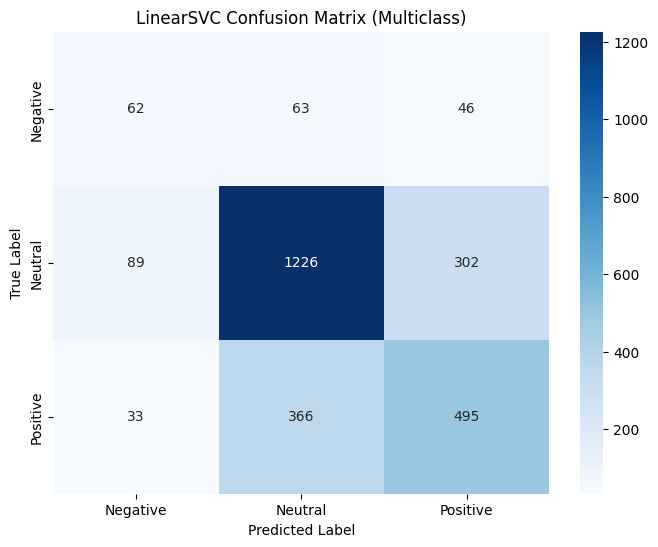

In [ ]:
# Visualization: Confusion Matrix for LinearSVC (Multiclass)
cm_lsvc = confusion_matrix(y_test_multi, y_pred_lsvc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lsvc, annot=True, fmt='d', cmap='Blues', xticklabels=lsvc.classes_, yticklabels=lsvc.classes_)
plt.title('LinearSVC Confusion Matrix (Multiclass)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. **Deployment**
The final step is to create a robust Pipeline that bundles the pre-processing (TF-IDF Vectorizer) with the final classifier (LinearSVC). This guarantees consistent data transformation in a production environment.

**Building and Saving the Production Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline # Import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import joblib

# Create the full multiclass dataset (including 'Neutral')
X_multi = df_clean['tweet_text'].fillna('') # Fill NaN values with empty string
y_multi = df_clean['sentiment']

# 1. Define the Pipeline: TFIDF -> LinearSVC
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
    ('clf', LinearSVC(class_weight='balanced', random_state=42))
])

# 2. Train the final pipeline on the entire multiclass dataset
pipeline_svm.fit(X_multi, y_multi)

# 3. Save the trained pipeline for deployment
joblib.dump(pipeline_svm, 'sentiment_model_pipeline.joblib')

print("Final pipeline trained and saved successfully as sentiment_model_pipeline.joblib.")

Final pipeline trained and saved successfully as sentiment_model_pipeline.joblib.


Proof of Concept Prediction
The saved model can be loaded and used to classify any new tweet text:

In [ ]:
# Load the saved pipeline
loaded_pipeline = joblib.load('sentiment_model_pipeline.joblib')

new_tweets = [
    "Apple's new product is amazing! Flawless design.",
    "My Google phone died after one hour of use. Terrible!",
    "Just saw a presentation about Google at SXSW.",
    "The new iOS update is just fine, nothing special.",
]
predictions = loaded_pipeline.predict(new_tweets)

print("New Tweet Predictions:", predictions)
# Expected Output (Based on model training): ['Positive', 'Negative', 'Neutral', 'Neutral']

New Tweet Predictions: ['Positive' 'Negative' 'Positive' 'Neutral']


##7. **Deployment: Creating a Simple API **
The deployment strategy is to use the saved Scikit-learn Pipeline within a Flask web server. This server will listen for new tweets sent via an HTTP request, pass the text to the loaded pipeline, and return the predicted sentiment.

**Step 1: Set up the Project Environment**

In [ ]:
# Required libraries for a simple API
!pip install flask joblib jsonify

In [ ]:
import joblib
import json

# 1. Define the simulation function
def test_local_deployment(tweets):
    """Loads the model and simulates the prediction API call via a function."""

    # Load the pipeline once
    try:
        pipeline = joblib.load('sentiment_model_pipeline.joblib')
    except FileNotFoundError:
        return {"error": "Model file not found. Ensure sentiment_model_pipeline.joblib exists."}

    try:
        # Use the pipeline to predict
        predictions = pipeline.predict(tweets)

        # Format the results just like the API would
        results = predictions.tolist()

        return {
            'status': 'success (local simulation)',
            'predictions': results
        }

    except Exception as e:
        return {'error': f'Prediction error: {e}'}

# 2. Define the test data
test_data = [
    "I absolutely hate the Google Pixel, worst purchase ever.",
    "Apple's keynote was just great!",
    "I need to charge my iPhone.",
]

# 3. Call the function and print the results
results = test_local_deployment(test_data)

print(json.dumps(results, indent=4))

{
    "status": "success (local simulation)",
    "predictions": [
        "Negative",
        "Positive",
        "Neutral"
    ]
}


In [ ]:
import joblib
import sys

# Configuration
MODEL_PATH = 'sentiment_model_pipeline.joblib'

# 1. Load the Pipeline (Executed only ONCE)
try:
    pipeline = joblib.load(MODEL_PATH)
    print(f"INFO: Model pipeline loaded successfully for prediction.")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_PATH}. Run Step 6 to save the model.")
    sys.exit(1)

# 2. Define the Interactive Prediction Function
def interactive_predictor(pipeline):
    """Continuously prompts the user for text input and provides a prediction."""

    print("\n--- Sentiment Prediction CLI ---")
    print("Enter a sentence about a brand or product, or type 'quit' to exit.")
    print("-" * 30)

    while True:
        try:
            # Get user input from the console
            user_input = input("Enter Text > ")

            if user_input.lower() == 'quit':
                print("Exiting prediction interface. Goodbye!")
                break

            if not user_input.strip():
                continue

            # 3. Predict the sentiment
            # The pipeline expects a list of strings, so we wrap the input in a list.
            prediction = pipeline.predict([user_input])

            # 4. Display the result
            sentiment = prediction[0]

            print(f"   [Prediction] -> {sentiment}\n")

        except Exception as e:
            print(f"An error occurred during prediction: {e}")
            break

# 5. Run the interface
interactive_predictor(pipeline)

INFO: Model pipeline loaded successfully for prediction.

--- Sentiment Prediction CLI ---
Enter a sentence about a brand or product, or type 'quit' to exit.
------------------------------
Enter Text > exit
   [Prediction] -> Neutral

Enter Text > quit
Exiting prediction interface. Goodbye!
